# Extended Pipeline of the Tweet Analysis project

This notebook serves as an overview of the Tweet Analysis process we employed. The notebook is annotated and divided into two main parts:

### I. Overview
### II. Model Building

**Example A** relies on using the data from the csv files in the `DATA` folder of the project.  This has the advantage of limiting the calls to the Twitter API.

**Example B** uses the full capabilities of the `HurricaneDataHandler` module and makes calls to the Twitter API to build all of the features of the Tweets for analysis. 

Both examples require initializing the `HurricaneDataHandler` as an object in the notebook.  This can take between 3 to 5 minutes. 

### III. Demonstration

**--------------------------**

In [1]:
import pandas as pd
import numpy as np
import re
import string
import contractions
import collections
from datetime import datetime
import time
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import tweepy
import matplotlib.pyplot as plt
import seaborn as sns
import config

In [2]:
# in the cloned repro remove the index numbers for the project modules 

# remove 6.A. from 6.A.data_handler.py
from data_handler import HurricaneDataHandler as DH

# remove 6.B. from 6.B.captain_eda.py
import captain_eda as eda

# remove 6.C. from 6.C.vectorize_text.py
from vectorize_text import TextVectors as TV

In [3]:
time1 = datetime.now()
print(f"Notebook started at {time1}")

Notebook started at 2022-12-21 09:52:13.764291


# I. Overview

The `DH` class augements Tweets with the full features found on the Twitter API and returns the Tweets as a pandas DataFrame. Additionally the class loads the labeled Tweets used in training as a feature of the class, the DataFrame `DH.labeled_with_features`.

Initializing `DH` requires interacting with the Twitter API and will impact rate-limiting. This requires a `config.py` file configured with the keys from an account with Twitter Developer Academic Research permissions. 

In [4]:
%%time
DATAH = DH()

27600
name 'Error' is not defined
Completed augmentation at 2022-12-21 09:55:32.140740. Consider rate limiting on API.
CPU times: user 23.1 s, sys: 153 ms, total: 23.3 s
Wall time: 3min 18s


Define the training dataset from the `DH` object.

In [5]:
# training dataframe
df_training = DATAH.labeled_with_features
print(df_training.shape)
df_training.head(2)

(18616, 18)


,tweet_id,text,author_id,created_at,conversation_id,entities,context_annotations,edit_history_tweet_ids,in_reply_to_user_id,attachments,lang,possibly_sensitive,public_metrics,referenced_tweets,reply_settings,source,class_label,hurricane
0,910783670134476800,"""Hurricane Maria Live Updates: Catastrophic Fl...",627954585,2017-09-21 08:32:03+00:00,910783670134476800,"{'annotations': [{'start': 1, 'end': 15, 'prob...","[{'domain': {'id': '13', 'name': 'Place', 'des...",[910783670134476800],no_value,no_value,en,no_value,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",no_value,everyone,no_value,caution_and_advice,Maria
1,912134938727780355,"Getting food to the island is, obviously, crit...",543450752,2017-09-25 02:01:30+00:00,912134938727780355,"{'urls': [{'start': 52, 'end': 75, 'url': 'htt...",no_value,[912134938727780355],no_value,no_value,en,no_value,"{'retweet_count': 3, 'reply_count': 0, 'like_c...","[(type, id)]",everyone,no_value,rescue_volunteering_or_donation_effort,Maria


Initialize the TFIDVectorizer and vectorize the text for the training data.  This will provide consistency between the models. 

In [6]:
%%time
# train the TFIDVectorizer, specify True for training
VECS = TV(df_training, True)

CPU times: user 5.8 s, sys: 23.7 ms, total: 5.82 s
Wall time: 5.86 s


Normalize the date ranges of the hurricane Tweets in order to be able to compare trends and patterns across the hurricanes. 

In [7]:
# normalize the date ranges for each hurricane
df_normed = eda.normalize_dates(df_training)

Storms being normalized:
(4681, 3) Maria
(6541, 3) Irma
(6361, 3) Harvey
(1033, 3) Matthew


## Examine the training data

This is the aggregate of behavior during the time period of a hurricane (30 days prior to landfall and approximately 60 days afterwards)

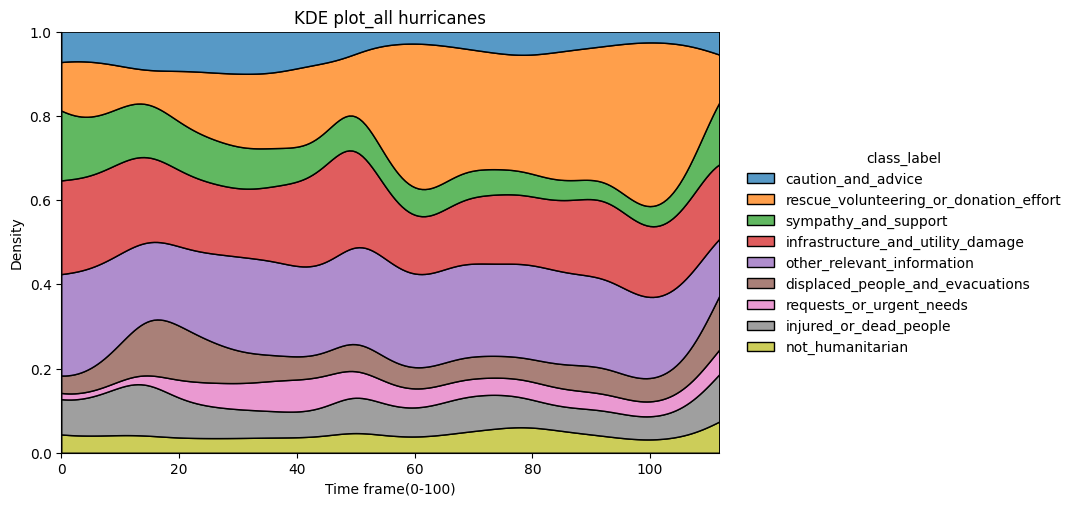

In [8]:
eda.all_kde(df_normed)
plt.show()

Compare the Tweet behavior during the individual hurricanes in the collection. 

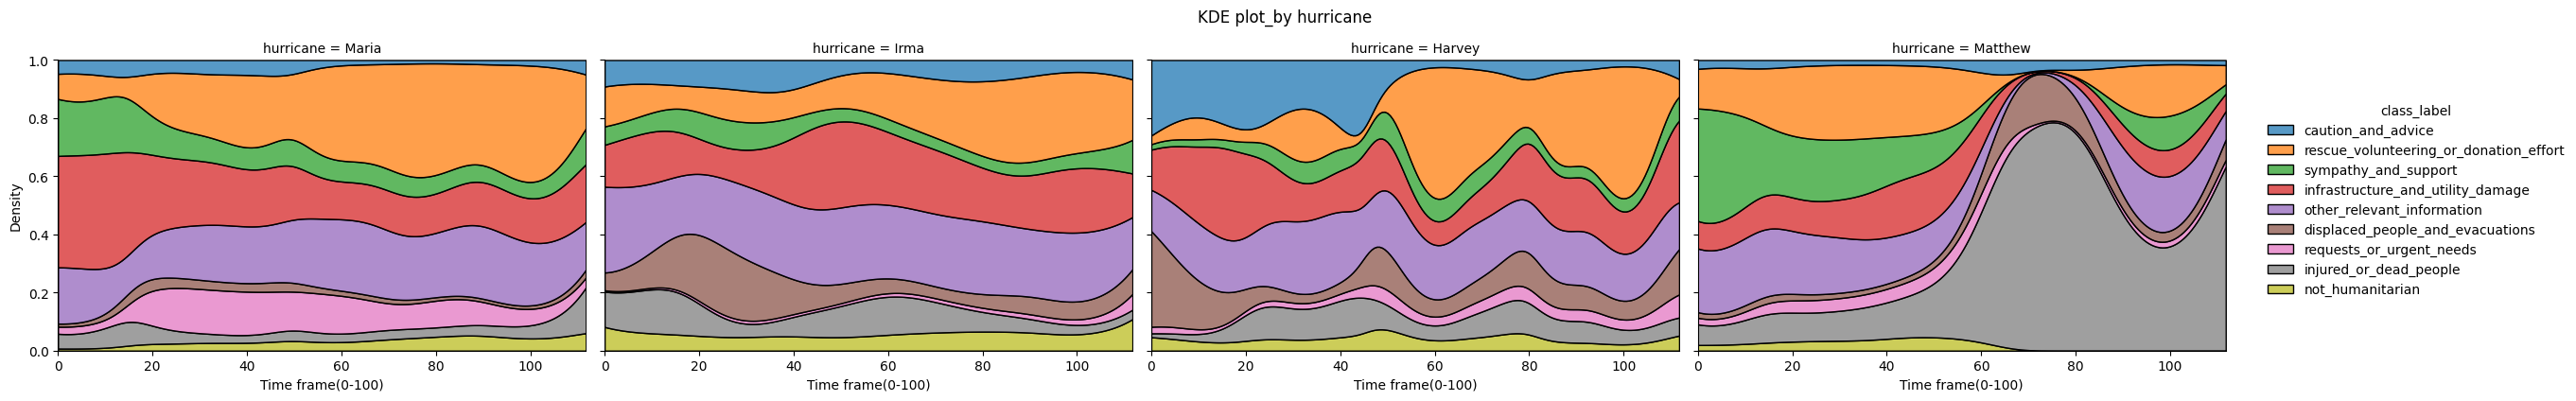

In [9]:
eda.comparison(df_normed)
plt.show()

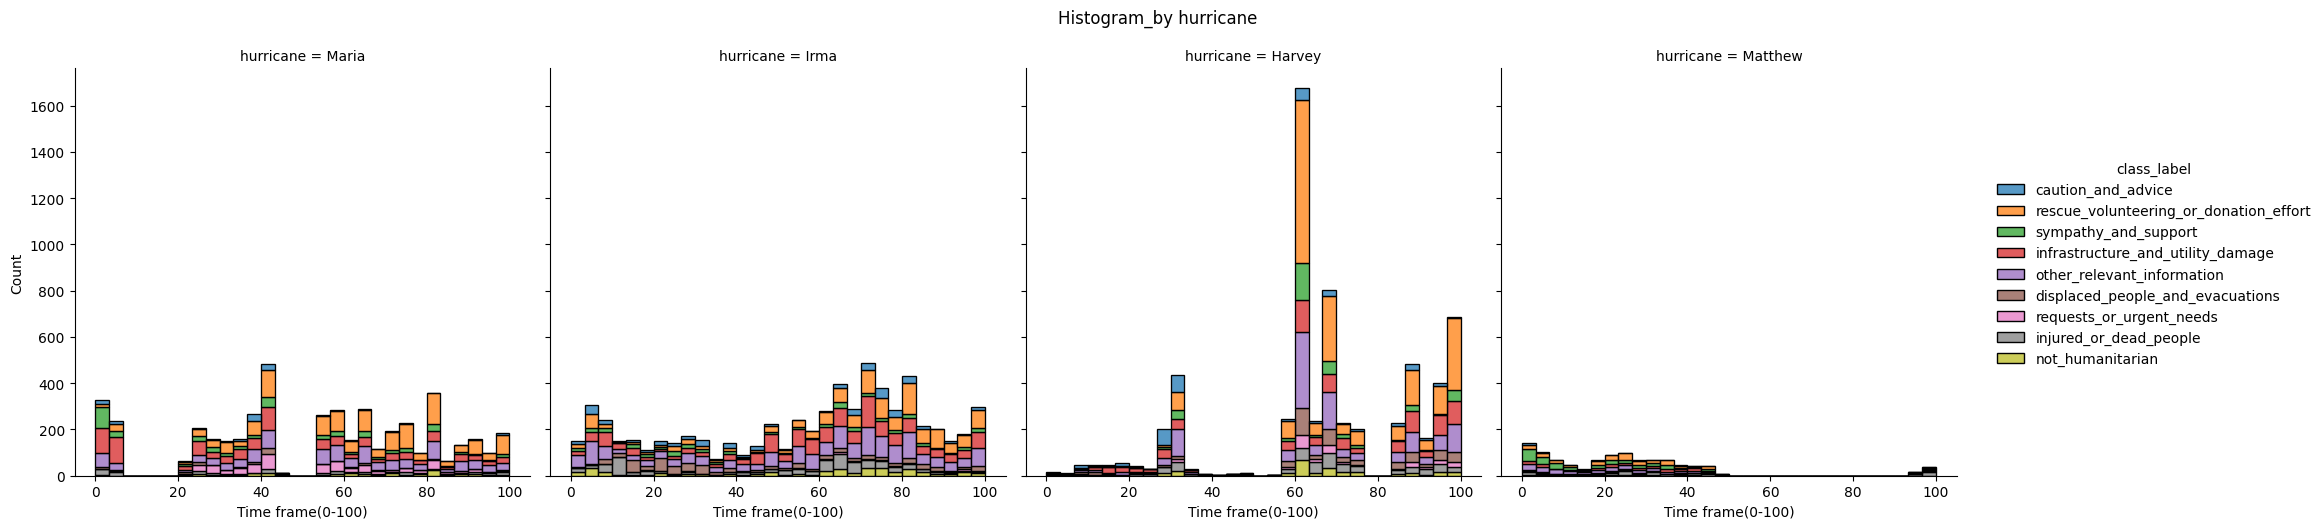

In [10]:
eda.displot_(df_normed)
plt.show()

Examine the class distributions in aggregate. 

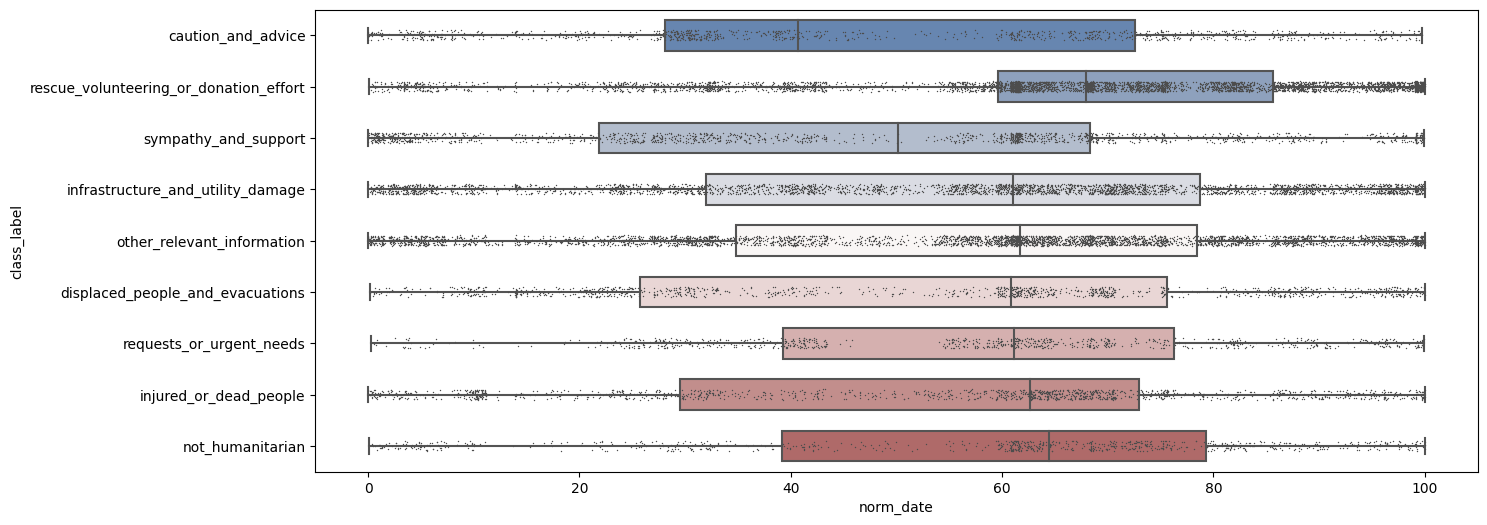

In [11]:
eda.strip_box(df_normed)
plt.show()

# II. Model Building

An initial set of Tweets is filtered by classifing them as YES they are related to hurricanes, or NO they are not related to hurricanes. 

## Develop the model to determine if YES or NO it is a Hurricane related Tweet 
Uncomment the example that you would like to use. 

### Example A
Load the sample dataset of a mix of Tweets from 2016 and 2017.  This dataset was formed by using the labeled Tweets from the [HUMAID datasets](https://crisisnlp.qcri.org/humaid_dataset.html#) and a collection of random Tweets from the same time period (see `2.B.ADDITIONAL_HURRICANE_DATA.ipynb` for the details. 

In [12]:
# Example A
# labeled set of data that establishes YES or NO hurricane related
df_mix = pd.read_csv('./DATA/mix_yes_no_hurricane_2016_17.csv')
df_mix.head(2)

,created_at,edit_history_tweet_ids,author_id,source,in_reply_to_user_id,text,conversation_id,class_label,reply_settings,tweet_id,entities,attachments,lang,public_metrics,referenced_tweets,possibly_sensitive,is_hurricane
0,2016-10-04 20:53:38+00:00,[783409770493571076],30316960,TweetDeck,NaN,Horrifying. My heart breaks for Haiti. Thinkin...,7.834098e+17,sympathy_and_support,everyone,783409770493571076,"{'urls': [{'start': 110, 'end': 133, 'url': 'h...",NaN,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[<ReferencedTweet id=783408890222444548 type=q...,NaN,1
1,2016-10-08 10:07:32+00:00,[784696725285908481],2182497116,dlvr.it,NaN,#BreakingNews Hurricane Matthew kills over 800...,7.846967e+17,injured_or_dead_people,everyone,784696725285908481,"{'urls': [{'start': 78, 'end': 101, 'url': 'ht...",NaN,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,1


### Example B
This example requires the use of the `DH` module to draw all of the Tweet features from the API.  This is the capability if a researcher only provided Tweet ids for analysis.  **Example B** uses the text file `mix_2016_17_ids_is` for training. This example will require significant consideration of the rate-limiting aspects of the Twitter API. 

In [13]:
# #Example B
# pattern = r"(\d+)\s(\d+)"
# ids_yes_no = eda.read_indices_and_labels('mix_2016_17_ids_is.txt', pattern)
# random.shuffle(ids_yes_no)

In [14]:
# Example B
# recover the full information on the Tweet from the Twitter API using the DataHandler
# tweet_ids = [x[0] for x in ids_yes_no]
# is_hurricane = [x[1] for x in ids_yes_no]
# len(tweet_ids), len(is_hurricane)

In [15]:
# Example B
# %%time
# # download the full tweet features
# df_mix = DATAH(tweet_ids, 0)
# df_mix.shape

In [16]:
# Example B
#df_mix['is_hurricane'] = is_hurricane[:df_mix.shape[0]]

Vectorize the mixed training data for use with the YES_NO model (Both **Example A** and **Example B**). The `VECS` class creates the vectorized text as the indendent variable for training. 

In [17]:
%%time
# create the X independent variables and y dependent variables for the model to observe
X = VECS(df_mix)
y = df_mix['is_hurricane']
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (26418, 191424)
Shape of y:  (26418,)
CPU times: user 5.89 s, sys: 648 µs, total: 5.89 s
Wall time: 5.89 s


In notebook `3.A.YES_NO_HURRICANE.ipynb` we conducted a comparison of models and parameters to see which model was best able to distinguish hurricane related Tweets from noise.  The winning model was the Support Vector Classifier with the parameters below. 

In [18]:
# use the parameters for the svc developed in prior testing
svc = SVC(C=10, gamma=1, kernel='rbf', random_state=42)

In [19]:
%%time
svc.fit(X, y)

CPU times: user 2min 2s, sys: 109 ms, total: 2min 2s
Wall time: 2min 2s


SVC(C=10, gamma=1, random_state=42)

## Develop the model to classify the hurricane related Tweets
Using the labeled training data from the HUMAID datasets (a features of the `VECS` text vectorizer) train the model to distinugish the classes of hurricane related Tweets. 

In [20]:
# use the provided labeled data from the 2016 and 2017 storms
X = VECS.vector_X
y = df_training['class_label']

Notebook `5.SUPERVISED_LEARNING_EDA_PREDICT.ipynb` demonstrates the comparison of models and parameters to determine which best classifies known hurricane related Tweets by category. 

In [21]:
# use the Logistic Regression with the parameters identified from prior testing
lr = LogisticRegression(C=1.6, multi_class='multinomial')

In [22]:
%%time
lr.fit(X, y)

CPU times: user 57.3 s, sys: 2min 20s, total: 3min 18s
Wall time: 28.7 s


/home/cameron/Documents/MADS/699/DisasterTweets/MODELS/ENVIRONMENT/working_specs/team_hit/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.6, multi_class='multinomial')

# II. Demonstration

**Use Case:** Given a collection of Tweet Ids and the name of the storm from the surrounding period of time, filter the list and examine those Tweets that are hurricane related for their underlying behavior. 

In [23]:
# separate the Tweet ids from the storm names for use later
pattern = r"(\d+)\s([a-zA-Z]+)"
ids_names = eda.read_indices_and_labels('./DATA/ids_hurricane_name.txt', pattern)

Length of id name tuples:  79060
Length of id name: 79055


In [24]:
target_ids = [x[0] for x in ids_names]
storm_names = [x[1] for x in ids_names]
len(target_ids), len(storm_names)

(79055, 79055)

### Example A
Use the previously downloaded Tweets with features and storm names to demonstrate the process.

In [25]:
df_unk = pd.read_csv('./DATA/all_seven_sample.csv')

/home/cameron/Documents/MADS/699/DisasterTweets/MODELS/ENVIRONMENT/working_specs/team_hit/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (0,2,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [26]:
df_unk.shape

(49000, 17)

### Example B
Use the `DH` object to recover the full Tweets with features from a list of Tweet ids and the associated storms.

In [27]:
# %%time
# recover the full information on the Tweet from the Twitter API using the DataHandler
# df_unk = DATAH(target_ids, 0)
# print("Final API call complete.")
# df_unk.shape

In [28]:
df_unk.head(2)

,id,text,author_id,created_at,public_metrics,reply_settings,entities,possibly_sensitive,edit_history_tweet_ids,source,lang,referenced_tweets,conversation_id,in_reply_to_user_id,attachments,withheld,hurricane
0,1295752275445657604,"religious, good for him. not an excuse to be a...",896029446867759105,2020-08-18T15:59:51.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,NaN,False,['1295752275445657604'],Twitter for iPhone,en,"[{'type': 'replied_to', 'id': '129575227137297...",1.295752e+18,8.960294e+17,NaN,NaN,Isaias
1,1308570075700563971,RT @gizellybicalho: @missfuraconer @mah_hurric...,906315330531848195,2020-09-23T00:53:12.000Z,"{'retweet_count': 75, 'reply_count': 0, 'like_...",everyone,"{'mentions': [{'start': 3, 'end': 18, 'usernam...",False,['1308570075700563971'],Twitter Web App,pt,"[{'type': 'retweeted', 'id': '1308569823933333...",1.308570e+18,NaN,NaN,NaN,Isaias


### Filter the Tweets that are not hurricane related

Vectorize the new text using the text vectorizer that trained the models. 

In [29]:
%%time
# vectorize the text using the vectorizer train for the models; False for not training a new vectorizer 
unk_vecs = VECS(df_unk)

CPU times: user 11.6 s, sys: 2.27 ms, total: 11.6 s
Wall time: 11.7 s


Using the YES_NO model predict and filter out the non-hurricane related Tweets. 

In [30]:
%%time
# predict YES/NO hurricane related
pred_yes_no = svc.predict(unk_vecs)

CPU times: user 43.4 s, sys: 0 ns, total: 43.4 s
Wall time: 43.4 s


In [31]:
len(pred_yes_no)

49000

In [32]:
# filter the new data
df_unk['is_hurricane'] = pred_yes_no
df_unk.head(2)

,id,text,author_id,created_at,public_metrics,reply_settings,entities,possibly_sensitive,edit_history_tweet_ids,source,lang,referenced_tweets,conversation_id,in_reply_to_user_id,attachments,withheld,hurricane,is_hurricane
0,1295752275445657604,"religious, good for him. not an excuse to be a...",896029446867759105,2020-08-18T15:59:51.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,NaN,False,['1295752275445657604'],Twitter for iPhone,en,"[{'type': 'replied_to', 'id': '129575227137297...",1.295752e+18,8.960294e+17,NaN,NaN,Isaias,0
1,1308570075700563971,RT @gizellybicalho: @missfuraconer @mah_hurric...,906315330531848195,2020-09-23T00:53:12.000Z,"{'retweet_count': 75, 'reply_count': 0, 'like_...",everyone,"{'mentions': [{'start': 3, 'end': 18, 'usernam...",False,['1308570075700563971'],Twitter Web App,pt,"[{'type': 'retweeted', 'id': '1308569823933333...",1.308570e+18,NaN,NaN,NaN,Isaias,0


In [33]:
df_tgt = df_unk[df_unk['is_hurricane'] == 1]
df_tgt.shape

(28758, 18)

### Predict the classes of the Tweets

Using the second model predict the class of the hurricane related Tweets. 

In [34]:
%%time
tgt_vecs = VECS(df_tgt)

CPU times: user 6.44 s, sys: 1.34 ms, total: 6.44 s
Wall time: 6.44 s


In [35]:
predict_classes = lr.predict(tgt_vecs)

In [36]:
df_tgt['class_label'] = predict_classes

/tmp/ipykernel_5117/3989052324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tgt['class_label'] = predict_classes


In [37]:
print(df_tgt.shape)
df_tgt.head(3)

(28758, 19)


,id,text,author_id,created_at,public_metrics,reply_settings,entities,possibly_sensitive,edit_history_tweet_ids,source,lang,referenced_tweets,conversation_id,in_reply_to_user_id,attachments,withheld,hurricane,is_hurricane,class_label
2,1281753978057797634,RT @ProjectLincoln: There is a big storm comin...,855464558,2020-07-11T00:55:36.000Z,"{'retweet_count': 7054, 'reply_count': 0, 'lik...",everyone,"{'annotations': [{'start': 100, 'end': 104, 'p...",False,['1281753978057797634'],Twitter for Android,en,"[{'type': 'retweeted', 'id': '1281637259138211...",1.281754e+18,NaN,NaN,NaN,Isaias,1,other_relevant_information
3,1298545133152083968,Here is the 5 a.m. advisory and forecast track...,906597498906693633,2020-08-26T08:57:40.000Z,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",everyone,"{'hashtags': [{'start': 51, 'end': 57, 'tag': ...",False,['1298545133152083968'],SocialNewsDesk,en,NaN,1.298545e+18,NaN,{'media_keys': ['3_1298545130765455365']},NaN,Isaias,1,caution_and_advice
6,1304857141593944070,RT @TheSteveCop: According to the 2pm Tropical...,832311020324581376,2020-09-12T18:59:20.000Z,"{'retweet_count': 8, 'reply_count': 0, 'like_c...",everyone,"{'hashtags': [{'start': 64, 'end': 69, 'tag': ...",False,['1304857141593944070'],Twitter for iPhone,en,"[{'type': 'retweeted', 'id': '1304840721095155...",1.304857e+18,NaN,NaN,NaN,Isaias,1,caution_and_advice


## Display the results of the class predictions

### Combine the hurricane names and Normalize the dates
Using the given data of Tweet ids and storm names create a single DataFrame with all of the information for a filtered set of Tweets with the category of information. 

### Example A

In [38]:
df_comb = df_tgt
df_comb.shape

(28758, 19)

In [39]:
df_comb.head(2)

,id,text,author_id,created_at,public_metrics,reply_settings,entities,possibly_sensitive,edit_history_tweet_ids,source,lang,referenced_tweets,conversation_id,in_reply_to_user_id,attachments,withheld,hurricane,is_hurricane,class_label
2,1281753978057797634,RT @ProjectLincoln: There is a big storm comin...,855464558,2020-07-11T00:55:36.000Z,"{'retweet_count': 7054, 'reply_count': 0, 'lik...",everyone,"{'annotations': [{'start': 100, 'end': 104, 'p...",False,['1281753978057797634'],Twitter for Android,en,"[{'type': 'retweeted', 'id': '1281637259138211...",1.281754e+18,NaN,NaN,NaN,Isaias,1,other_relevant_information
3,1298545133152083968,Here is the 5 a.m. advisory and forecast track...,906597498906693633,2020-08-26T08:57:40.000Z,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",everyone,"{'hashtags': [{'start': 51, 'end': 57, 'tag': ...",False,['1298545133152083968'],SocialNewsDesk,en,NaN,1.298545e+18,NaN,{'media_keys': ['3_1298545130765455365']},NaN,Isaias,1,caution_and_advice


### Example B:

In [40]:
# Example B
# # form a dataframe for ids and storm name
# df_ids_names = pd.DataFrame({'id': target_ids, 'hurricane': storm_names})
# df_ids_names['id'] = df_ids_names['id'].astype('int64')
# df_ids_names.shape

In [41]:
# Example B
# df_comb = df_tgt.merge(df_ids_names, on='id', how='inner')
# df_comb.shape

In [42]:
# df_comb.head(2)

In [43]:
# normalize the date ranges for each hurricane
df_normed_tgt_othr = eda.normalize_dates(df_comb)

Storms being normalized:
(4049, 3) Isaias
(3683, 3) Nicholas
(3540, 3) Ian
(4380, 3) Florence
(4704, 3) Arthur
(3564, 3) Barry
(4838, 3) Sandy


/home/cameron/Documents/MADS/699/DisasterTweets/MODELS/ENVIRONMENT/working_specs/team_hit/lib/python3.10/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Illustration of class imbalance:
The "other_relevant_information" class is consistently the most dominant. 

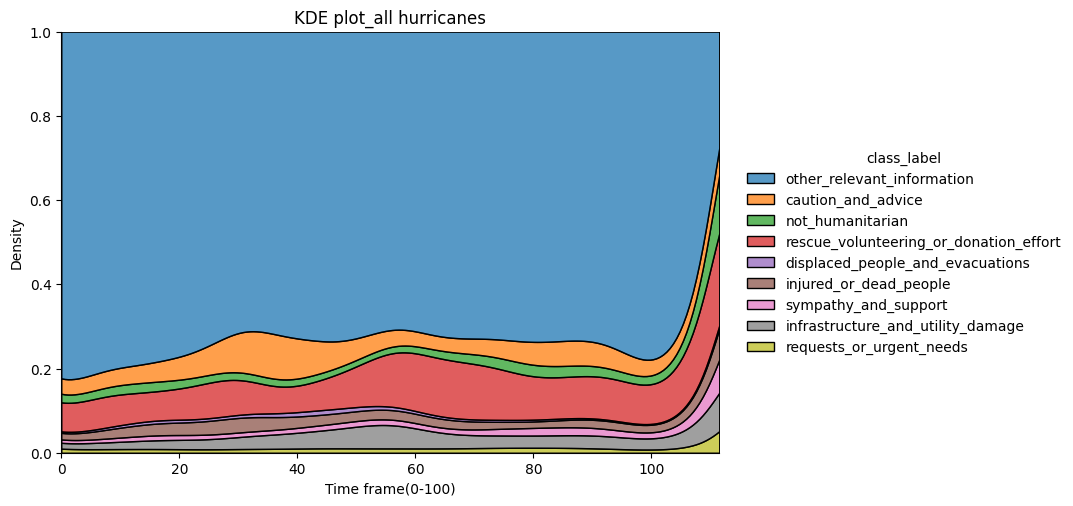

In [44]:
eda.all_kde(df_normed_tgt_othr)
plt.show()

Filter out the imbalanced class to see the underlying patterns.

In [45]:
# filter the class imbalance
df_normed_tgt = df_normed_tgt_othr[df_normed_tgt_othr['class_label'] != 'other_relevant_information']
df_normed_tgt.shape

(7368, 4)

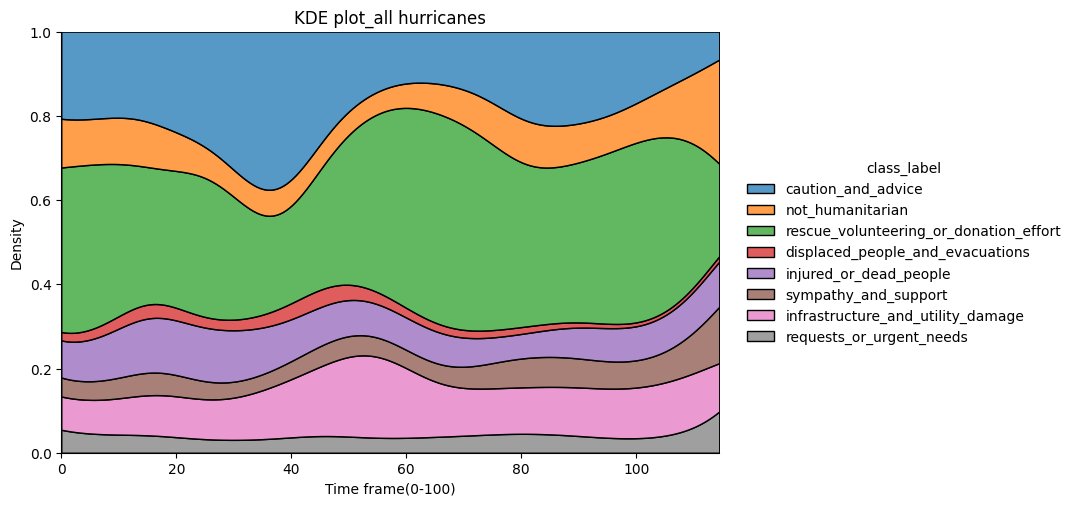

In [46]:
eda.all_kde(df_normed_tgt)
plt.show()

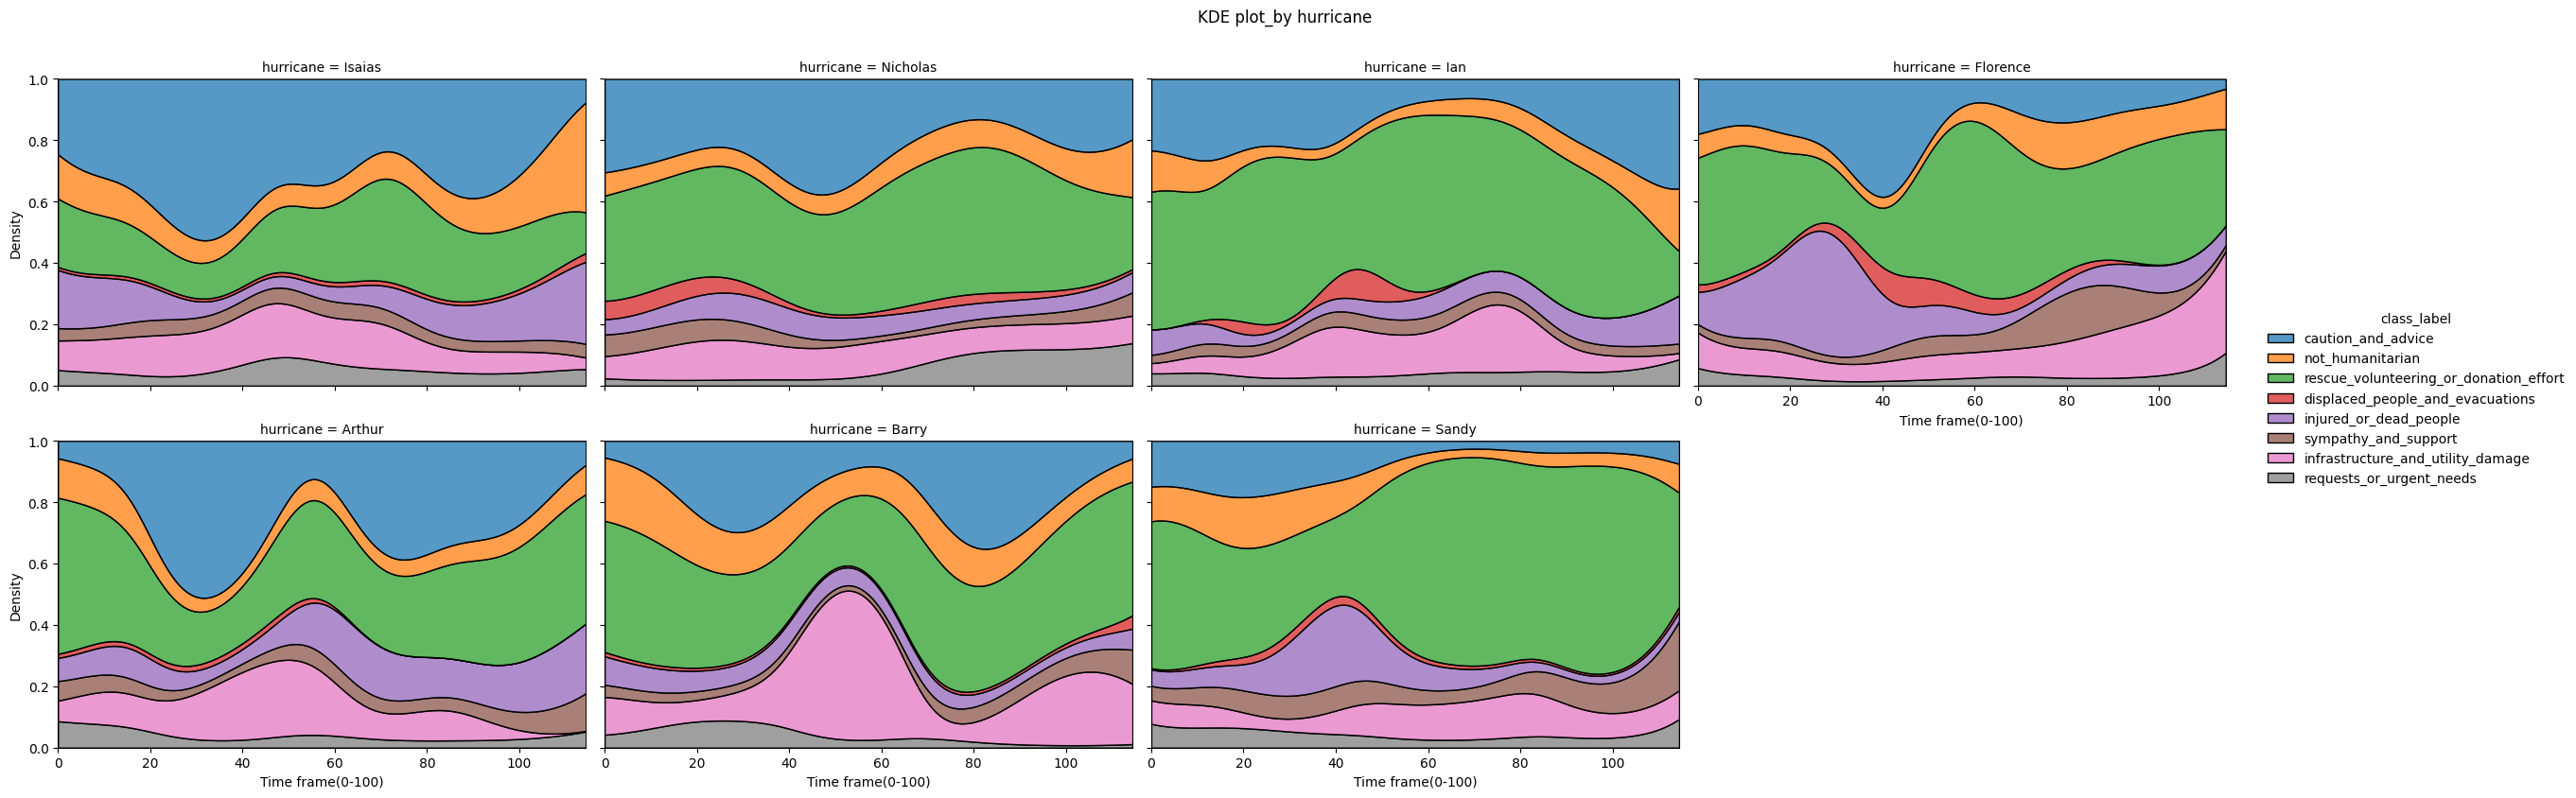

In [47]:
eda.comparison(df_normed_tgt)
plt.show()

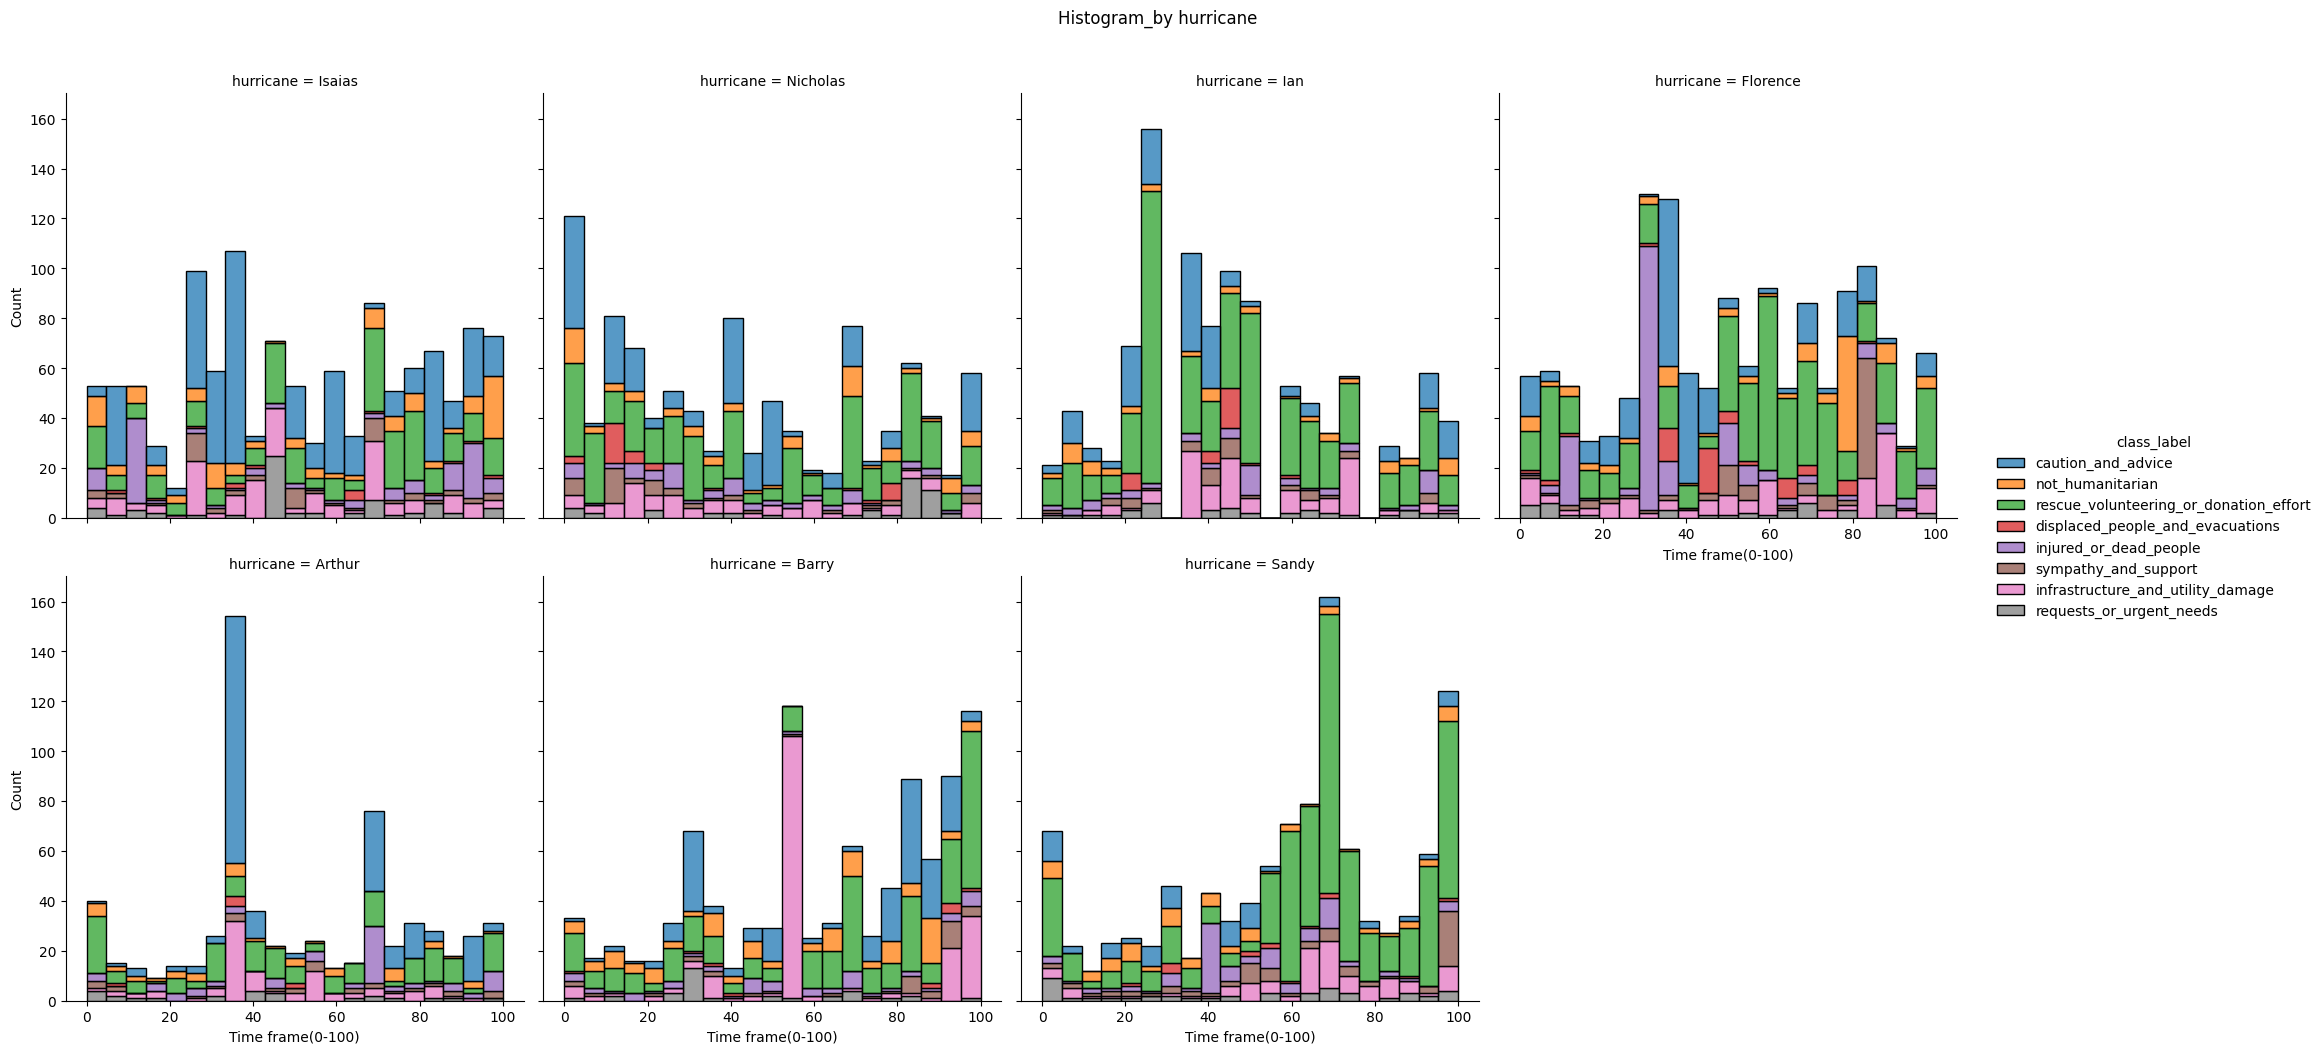

In [48]:
eda.displot_(df_normed_tgt)
plt.show()

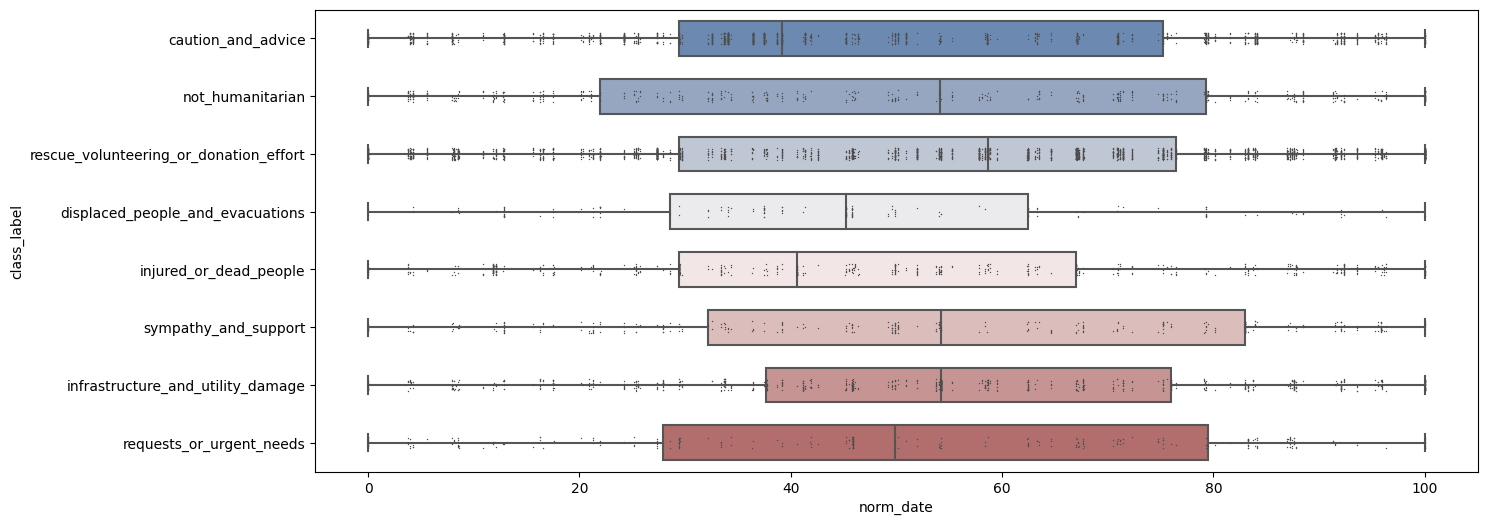

In [49]:
eda.strip_box(df_normed_tgt)
plt.show()

In [50]:
time2 = datetime.now()
print(f"Time to complete notebook: {time2 - time1}")

Time to complete notebook: 0:07:13.806751
